In [1]:
import sys; sys.path.append('..')
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

exp_name = 'cifar10-icons-hpo-00004'
exp_dir = f'../../loss-patterns-old/experiments/{exp_name}'
logs_export_dir = f'../../loss-patterns-old/logs_export/{exp_name}'

# val_acc_diffs = pd.read_csv(f'{logs_export_dir}/val_acc_diffs.csv', index_col=0)
hps = pd.read_csv(f'{logs_export_dir}/hps.csv', index_col=0)
# summaries = [load_config(f'{exp_dir}/summaries/{exp_name}.yml') for exp_name in hps.index.values]
masks = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/mask.npy') for hpo_exp_name in hps.index.values]
minima_grid_train = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_train.npy') for hpo_exp_name in hps.index.values]
minima_grid_test = [np.load(f'{exp_dir}/custom_data/{hpo_exp_name}/minima_grid_test.npy') for hpo_exp_name in hps.index.values]

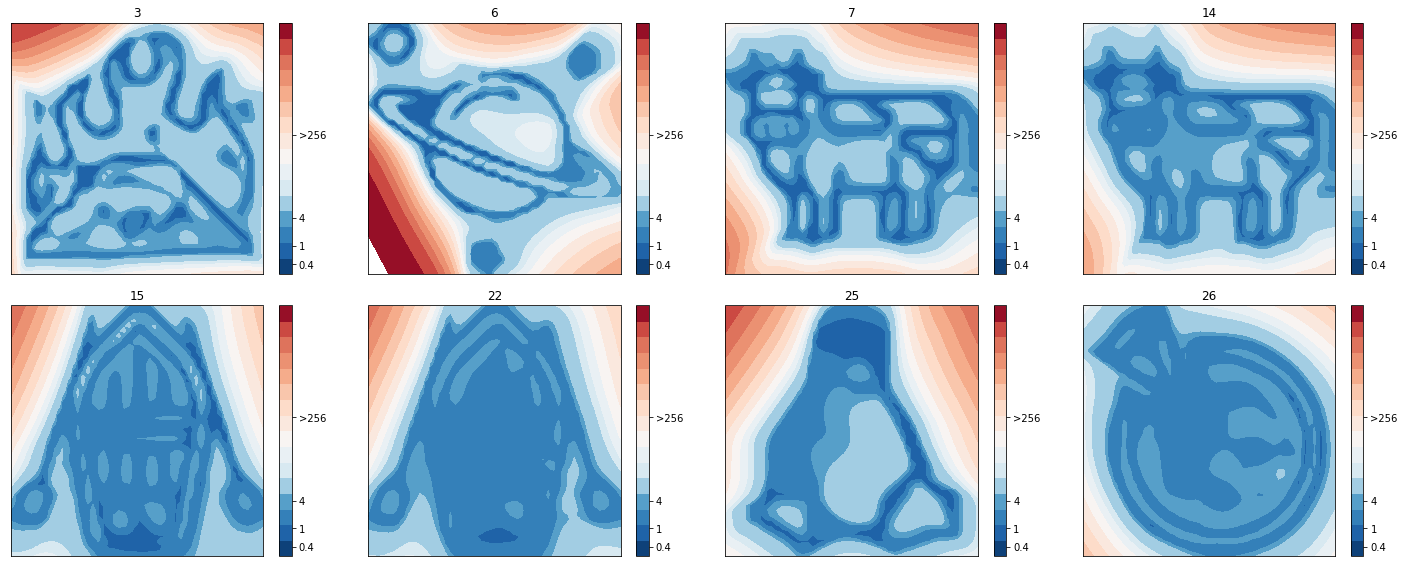

In [2]:
import matplotlib
from matplotlib import ticker, cm
from skimage.io import imread
from tqdm import tqdm

chosen_images = [3, 6, 7, 14, 15, 22, 25, 26]
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4))
fig.tight_layout()

# norm = matplotlib.colors.Normalize(-1,1)
# colors = [[norm(-1.0), "blue"],
#           [norm(-0.6), "lightblue"],
#           [norm(0.),   "white"],
#           [norm( 0.6), "white"],
#           [norm( 1.0), "red"]]

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

for i in range(nrows):
    for j in range(ncols):
        pad = 5
        pad, x_num_points, y_num_points = 5, 50, 50
        image_idx = i * ncols + j
        if image_idx >= len(chosen_images): break
        image_idx = chosen_images[image_idx]
        mask = masks[image_idx]
        xs = np.linspace(-pad, mask.shape[0] + pad, x_num_points)
        ys = np.linspace(-pad, mask.shape[1] + pad, y_num_points)
        X, Y = np.meshgrid(xs, ys)
        scores = minima_grid_test[image_idx]
        
        #cntr = axes[i][j].contourf(X, Y, scores[::-1,::-1,1], cmap="RdBu_r", levels=np.linspace(0., 0.99, 100))
        cntr = axes[i][j].contourf(X, Y, scores[::-1,::-1,0], locator=ticker.LogLocator(base=2), cmap='RdBu_r',
                                   #levels=np.concatenate([np.linspace(-4.5, 4, 21), np.linspace(7.5, 50, 18), np.linspace(100, 50000, 10)]))
                                   levels=np.concatenate([
                                       np.logspace(-2., 2.5, 5, base=2),
                                       np.logspace(5, 12, 10, base=2),
                                       [10000, 50000]
                                   ]))
        axes[i][j].set_title(image_idx)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        cbar = fig.colorbar(cntr, ax=axes[i][j], ticks=[0.4, 1, 4, 256])
        cbar.ax.set_yticklabels(['0.4', '1', '4', '>256']) 
        #plt.savefig('tmp.png', transparent = True, bbox_inches = 'tight', pad_inches=0)
        #plt.close(fig)

        #images.append(imread('tmp.png'))

In [36]:
import matplotlib
from matplotlib import ticker, cm
from matplotlib import gridspec
from skimage.io import imread
from skimage import util
from tqdm import tqdm

images_idx = list(range(28))

for mode in ('train', 'test'):
    for image_idx in images_idx:
        pad = 5
        pad, x_num_points, y_num_points = 5, 50, 50
        mask = masks[image_idx]
        xs = np.linspace(-pad, mask.shape[0] + pad, x_num_points)
        ys = np.linspace(-pad, mask.shape[1] + pad, y_num_points)
        X, Y = np.meshgrid(xs, ys)
        scores = minima_grid_train[image_idx] if mode == 'train' else minima_grid_test[image_idx]

        fig = plt.figure(figsize=(12, 4))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 2])

        plt.subplot(gs[0])
        #plt.title('Original mask')
        #plt.imshow(util.pad(masks[image_idx], pad_width=[(0, 50), (30, 30)], mode='constant', constant_values=1), cmap="gray")
        plt.imshow(masks[image_idx], cmap="gray")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(gs[1])
        plt.title('Loss surface')
        cntr = plt.contourf(X, Y, scores[::-1,:,0], locator=ticker.LogLocator(base=2), cmap='RdBu_r',
                            levels=np.concatenate([
                                           np.logspace(-3., 2.5, 5, base=2),
                                           np.logspace(5, 12, 10, base=2),
                                           [10000, 50000]
                                       ]))
        plt.xticks([])
        plt.yticks([])
        cbar = fig.colorbar(cntr, ticks=[0.4, 1, 4, 256])
        cbar.ax.set_yticklabels(['0.4', '1', '4', '>256']) 

        plt.subplot(gs[2])
        plt.title(f'Accuracy surface')
        cntr = plt.contourf(X, Y, scores[::-1,:,1], cmap="RdBu_r", levels=np.linspace(0, 1, 51))
        plt.colorbar(cntr)
        plt.xticks([])
        plt.yticks([])

        plt.savefig(f'../full-results/cifar10/{mode}-{image_idx}.png', transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

In [4]:
for mode in ('train', 'test'):
    for image_idx in [0, 13]:
        pad = 5
        pad, x_num_points, y_num_points = 5, 50, 50
        mask = masks[image_idx]
        xs = np.linspace(-pad, mask.shape[0] + pad, x_num_points)
        ys = np.linspace(-pad, mask.shape[1] + pad, y_num_points)
        X, Y = np.meshgrid(xs, ys)
        minima_grid = minima_grid_train if mode == 'train' else minima_grid_test
        scores = minima_grid[image_idx]
        fig = plt.figure(figsize=(6, 5))
        cntr = plt.contourf(X, Y, scores[::-1,:,0], locator=ticker.LogLocator(base=2), cmap='RdBu_r',
                            levels=np.concatenate([
                                           np.logspace(-3., 2.5, 5, base=2),
                                           np.logspace(5, 12, 10, base=2),
                                           [10000, 50000]
                                       ]))
        plt.xticks([])
        plt.yticks([])
        cbar = fig.colorbar(cntr, ticks=[0.4, 1, 4, 256])
        cbar.ax.set_yticklabels(['0.4', '1', '4', '>256'])
        cbar.ax.tick_params(labelsize=18)
        plt.savefig(f'../cifar10-images/{image_idx}-{mode}.png', transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

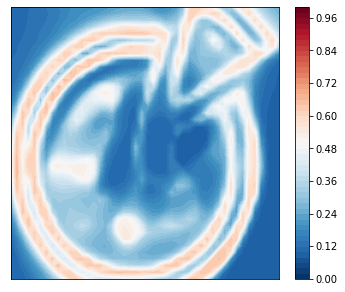

In [9]:
for image_idx in [19]:
    pad = 5
    pad, x_num_points, y_num_points = 5, 50, 50
    mask = masks[image_idx]
    xs = np.linspace(-pad, mask.shape[0] + pad, x_num_points)
    ys = np.linspace(-pad, mask.shape[1] + pad, y_num_points)
    X, Y = np.meshgrid(xs, ys)
    scores = minima_grid_test[image_idx]
    
    m, mw = 4, 2
    X, Y, scores = X[m:-m, mw:-mw], Y[m:-m, mw:-mw], scores[m:-m, mw:-mw]
    
    # plt.title(f'Accuracy surface')
    fig = plt.figure(figsize=(6, 5))
    cntr = plt.contourf(X, Y, scores[::-1,:,1], cmap="RdBu_r", levels=np.linspace(0, 1, 51))
    cbr = fig.colorbar(cntr)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks([])
    plt.yticks([])